# **ANÁLISE DA ROBUSTEZ DE ALGORITMOS DE APRENDIZADO DE MÁQUINA COMO FERRAMENTA DE APOIO AO DIAGNÓSTICO PRECOCE DO TRANSTORNO DO ESPECTRO AUTISTA**

## **Definição do problema**

 Contextualização:O diagnóstico definitivo do Transtorno do Espectro Autista (TEA) é um processo clínico complexo, que pode ser longo e oneroso. A demora nesse processo atrasa o acesso a intervenções essenciais. O projeto propõe o uso de Machine Learning como forma complementar ao trabalho médico, atuando como uma ferramenta de triagem inteligente através da análise de padrões em dados comportamentais obtidos através do questionário AQ-10 (Autism Spectrum Quotient).

---

 Objetivos:
 - Ferramenta de Auxílio à Triagem: Desenvolver um modelo preditivo capaz de estimar a probabiidade de TEA, servindo como "segunda opinião" baseada em dados.
 - Análise da Robustez: avaliar a estabilidade dos algoritmos diante de incertezas ou ruídos nos dados de questionários

---

 Personas:

 Médicos da Atenção Primária: Necessitam de uma ferramenta de suporte à decisão para validar o encaminhamento de pacientes para neurologistas ou psiquiatras
 Especialistas (Neuropediatras): Utilizam a triagem automatizada para receber pacientes com histórico pré-analisado, otimizando o tempo de consulta.

 Pais e Cuidadores: Desejam um indicativo inicial rápido e acessível antes de buscar a ajuda clínica completa

 Crianças (4 a 11 anos): Beneficiários finais que podem ter acesso mais rápido a terapias adequadas.  

---

 Pergunta de Pesquisa Principal:
 1) É possível desenvolver uma ferramenta de triagem automatizada que apresente alta sensibilidade e robustez a ruídos, auxiliando eficazmente a tomada de decisão clínica no encaminhamento de suspeitas de TEA?

**Criação ou referência do dataset**

O dataset utilizado foi o BASE-AQ-10, que é do tipo coletado. A base  contém 509 amostras de crianças entre 4 e 11 anos, sendo dividida em duas classes: 257 possuem TEA e 252 não possuem.

O conjunto de dados têm 10 atributos binários que representam as respostas às perguntas do método de triagem (A1 a A10), assim como outros atributos relativos ao gênero, etnia, icterícia, TEA na família, residência, idade e pontuação/ resultados da
triagem.
As respostas foram previamente convertidas em 0 ou 1 antes da disponibilização da base, com base na opção selecionada em uma escala para cada resposta pelo usuário.
As respostas resultaram em atribuição de um ponto quando **positivas para as perguntas 1, 5, 7 e 10** e negativas para as perguntas 2, 3, 4, 6, 8 e 9.

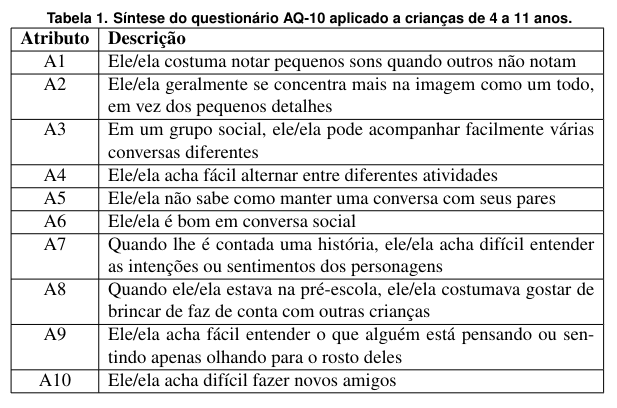

In [5]:
import kagglehub
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'kagglehub'

In [ ]:
path= kagglehub.dataset_download("basmarg/autism-screening-child-two-version")
print("Path to dataset files:", path)

df= pd.read_csv('/kaggle/input/autism-screening-child-two-version/Child-Data2018.csv')
print(df.head())

Using Colab cache for faster access to the 'autism-screening-child-two-version' dataset.
Path to dataset files: /kaggle/input/autism-screening-child-two-version
   Case No  A1  A2  A3  A4  A5  A6  A7  A8  A9  ...  Jaundice   Family_ASD  \
0        1   0   1   1   0   0   1   1   0   0  ...        yes          no   
1        3   0   1   1   1   1   1   1   0   0  ...        yes          no   
2        4   0   1   1   1   1   1   0   1   1  ...         no          no   
3        8   0   1   1   0   1   1   1   0   0  ...        yes          no   
4        9   0   0   1   1   1   1   0   1   0  ...         no          no   

  Residence Used_App_Before Why taken the screening  Score Screening Type  \
0     Libya              no                      NaN     5     4-11 years   
1     Libya             yes                   ??????     7     4-11 years   
2    Russia              no                      NaN     8     4-11 years   
3     Libya              no                      NaN     5    

## **Pré-processamento dos dados**

Para a limpeza dos dados, os atributos que são meta-informações (“Why taken the screening”, "Used App Before”, “Screening Type”, “Residence”, "Language" e "User") foram removidos, assim como o atributo “Score”. O “Ethnicity” foi codificado numericamente, os atributos categóricos: “Sex”, “Family ASD”, “Jaundice” e o rótulo
“Class” tiveram seus valores codificados em 0 e 1.
Além disso, normalizamos o conjunto de dados com a Standard Scaler para aplicar os modelos.

Para treinamento do modelo, foi utilizado 70% do conjunto de dados, reservamos o 30% restante para os testes.

In [ ]:
df.columns= df.columns.str.strip() #retira os espaços em branco dos meta-dados

colunasADeletar= [
    'Case No', 'Why taken the screening', 'Used_App_Before',
    'Screening Type', 'Residence', 'Language', 'User', 'Score'
]
df_processed= df.drop (columns= colunasADeletar, errors='ignore')

df_processed['Sex']= df_processed['Sex'].replace({'m': 1, 'f': 0})
df_processed['Jaundice']= df_processed['Jaundice'].replace({'yes': 1, 'no': 0})
df_processed['Family_ASD']= df_processed['Family_ASD'].replace({'no': 0, 'yes': 1})
df_processed['Class']= df_processed['Class'].replace({'YES': 1, 'NO': 0})

df_processed= pd.get_dummies(df_processed, columns=['Ethnicity'], drop_first=True) #utiliza o ONE-HOT encoding

y= df_processed['Class'].copy()
X= df_processed.drop(columns=['Class']).copy()
X= X.apply(pd.to_numeric, errors='coerce').fillna(0)

scaler= StandardScaler()
X_scaled_array= scaler.fit_transform(X)
X_scaled= pd.DataFrame(X_scaled_array, columns= X.columns)
print(f"O escalonamento foi concluído: {X_scaled.shape}")

X_train, X_test, y_train, y_test= train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

O escalonamento foi concluído: (509, 22)


/tmp/ipython-input-2737326285.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['Sex']= df_processed['Sex'].replace({'m': 1, 'f': 0})
/tmp/ipython-input-2737326285.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed['Jaundice']= df_processed['Jaundice'].replace({'yes': 1, 'no': 0})
/tmp/ipython-input-2737326285.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To 

Os valores estão normalizados na escala Standard Scaler, por isso há valores menores que -1. Dessa forma, valores extremos como bem menores que -1 ou com o intervalo interquartil alto, representam os valores originais sendo muito dispersos ou com muitos outliers. Para exemplificar, é possível notar uma maior diferença entre as respostas das crianças às questões A1 e A5.

In [ ]:
estatisticas= X_scaled.describe().T
tabela_estatisticas= estatisticas.style.format("{:.2f}")

print ("Estatística descritiva das variáveis (total de participantes, média, desvio padrão, valor mínimo, quartis e valor máximo)")
tabela_estatisticas #printa o resultado

Estatística descritiva das variáveis (total de participantes, média, desvio padrão, valor mínimo, quartis e valor máximo)


,count,mean,std,min,25%,50%,75%,max
A1,509.00,0.00,1.00,-1.42,-1.42,0.71,0.71,0.71
A2,509.00,-0.00,1.00,-1.11,-1.11,0.90,0.90,0.90
A3,509.00,0.00,1.00,-1.75,0.57,0.57,0.57,0.57
A4,509.00,-0.00,1.00,-1.10,-1.10,0.91,0.91,0.91
A5,509.00,-0.00,1.00,-1.59,-1.59,0.63,0.63,0.63
A6,509.00,0.00,1.00,-1.54,-1.54,0.65,0.65,0.65
A7,509.00,0.00,1.00,-1.23,-1.23,0.81,0.81,0.81
A8,509.00,0.00,1.00,-0.99,-0.99,-0.99,1.01,1.01
A9,509.00,-0.00,1.00,-0.96,-0.96,-0.96,1.04,1.04
A10,509.00,0.00,1.00,-1.54,-1.54,0.65,0.65,0.65


([<matplotlib.axis.XTick at 0x7f2de703e9c0>,
 [Text(0, 0, 'Sem TEA'), Text(1, 0, 'TEA')])

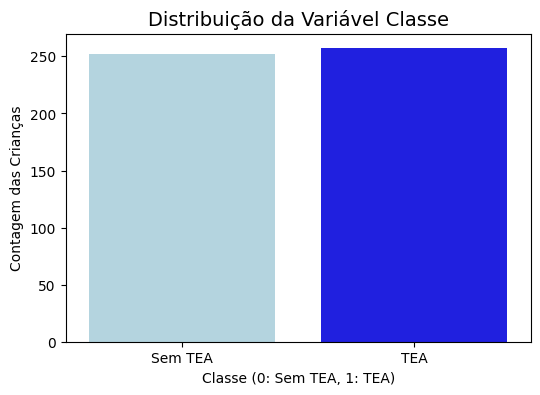

In [ ]:
plt.figure (figsize=(6, 4))
sns.countplot(x= y, hue= y, palette= ['lightblue', 'blue'], legend= False)
plt.title('Distribuição da Variável Classe', fontsize=14)
plt.xlabel('Classe (0: Sem TEA, 1: TEA)')
plt.ylabel('Contagem das Crianças')
plt.xticks(ticks=[0, 1], labels=['Sem TEA', 'TEA'])

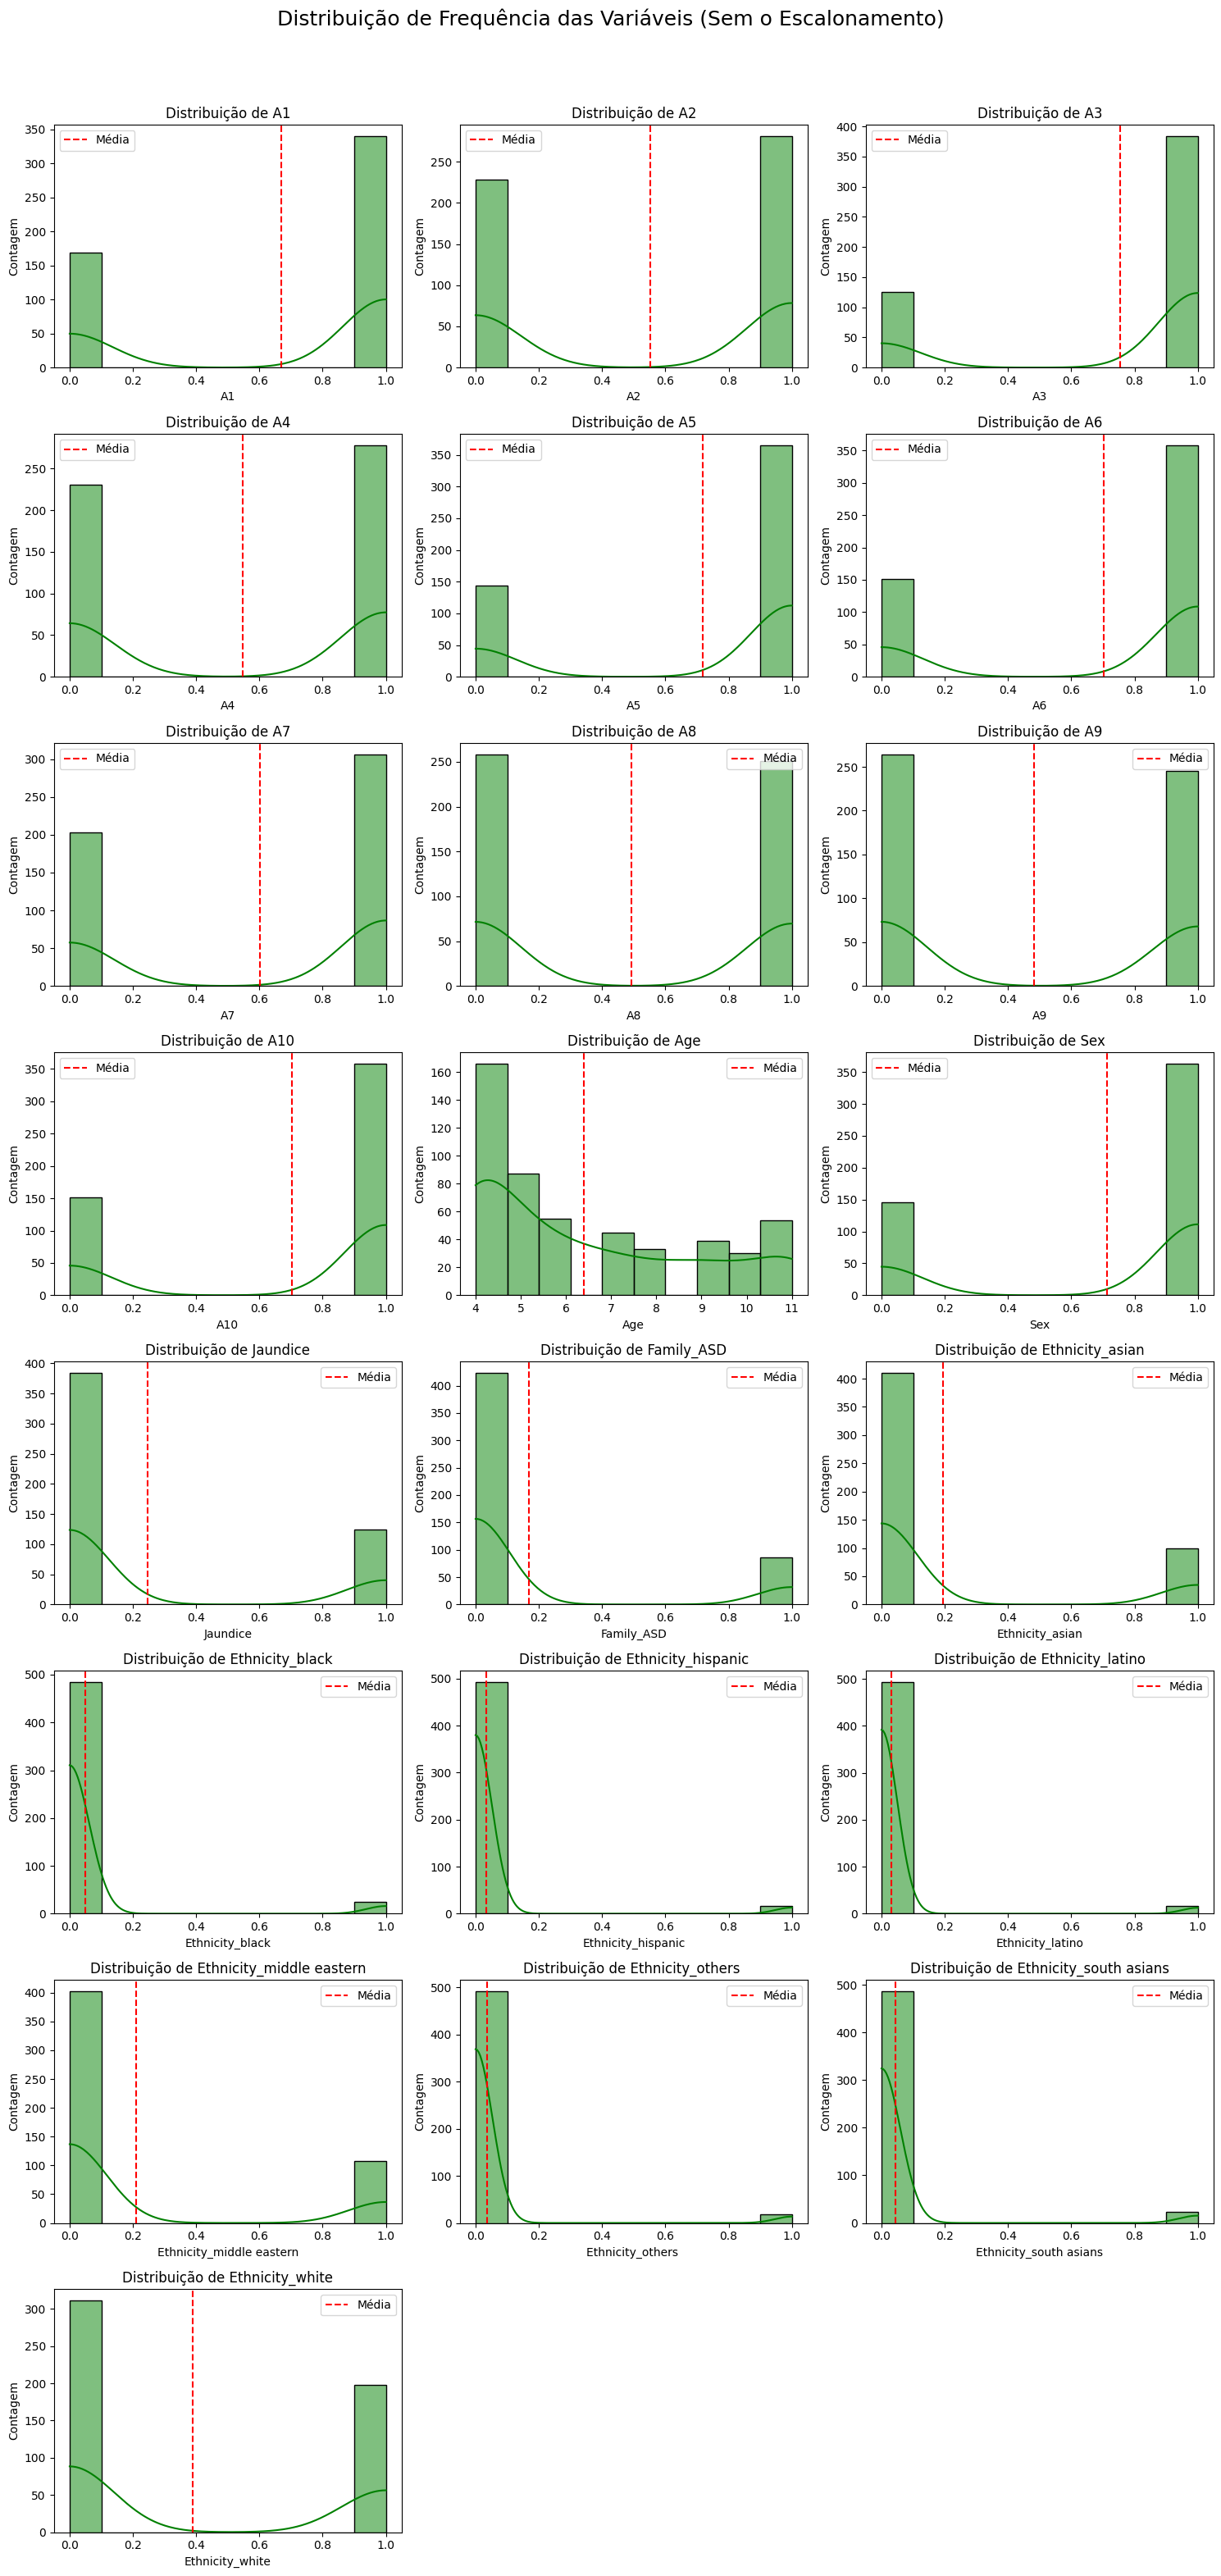

In [ ]:
n_features= X.shape[1] #armazena o número de colunas df X na variável n_features
n_cols= 3
n_rows= int (np.ceil (n_features / n_cols))

fig, axes= plt.subplots (n_rows, n_cols, figsize= (15, n_rows * 4))
axes= axes.flatten()

for i, col in enumerate (X.columns):
    sns.histplot (X[col], kde=True, ax=axes[i], bins= 10, color= 'green')
    axes[i].set_title (f'Distribuição de {col}')
    axes[i].set_ylabel('Contagem', fontsize= 10)
    axes[i].axvline(X[col].mean(), color='red', linestyle='--', label='Média')
    axes[i].legend()

for i in range(n_features, len(axes)): #oculta eixos vazios ao final
    axes[i].axis('off')

plt.suptitle ('Distribuição de Frequência das Variáveis (Sem o Escalonamento)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])

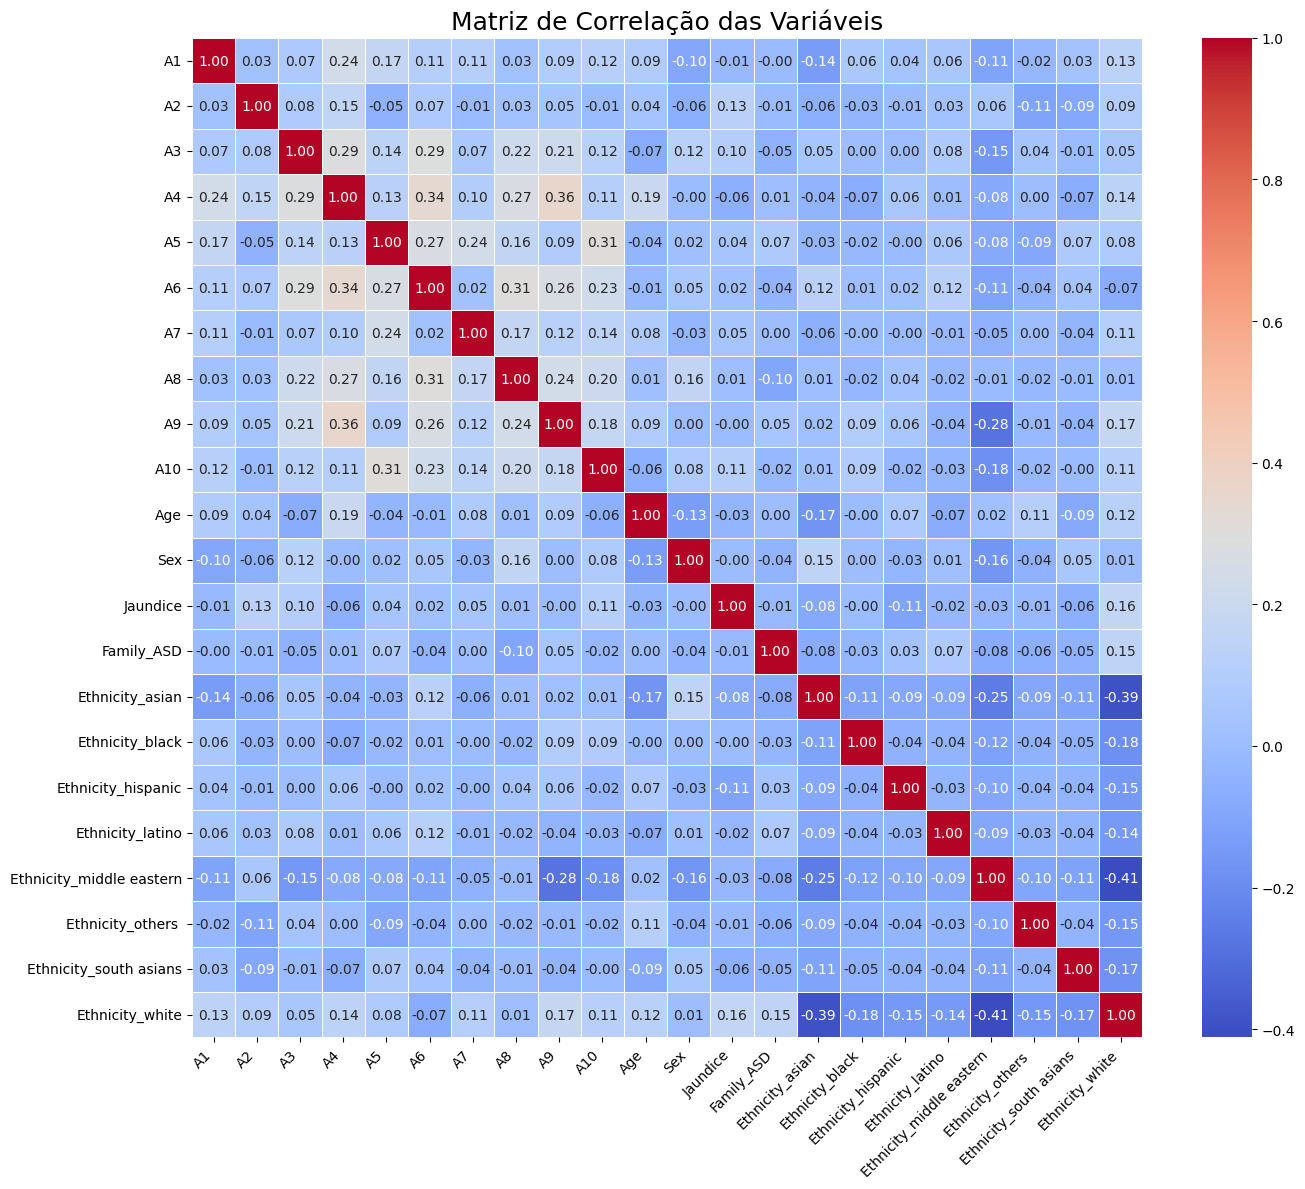

In [ ]:
matriz_correlacao= X_scaled.corr()
plt.figure(figsize=(14, 12))

sns.heatmap(
    matriz_correlacao,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    cbar=True
)
plt.title('Matriz de Correlação das Variáveis', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

## **Seleção e justificativa dos modelos**

Os modelos escolhidos foram de aprendizado supervisionado, mais especificamente, de classificação, a fim de possibilitar a predição da variável binária "Class". Os modelos foram Support Vector Machine (SVM) com kernel linear, Multilayer Perceptron (MLP) e Random Forest (RF), porque foram os que tiveram melhor desempenho em trabalhos relacionados.

Como exemplo, o **RF** geralmente tem uma performance superior a outros modelos de classificação para diagnósticos médicos, pois lida melhor com relações complexas nos dados e usa a aleatoriedade para reduzir a variância e o risco de overfitting, resultando em um modelo muito estável e robusto.

## **Algoritmo de treinamento**

Nesta etapa, instanciamos e treinamos os algoritmos selecionados com base na revisão bibliográfica (Lino et al., 2024; Artoni et al., 2022). O objetivo é aprender os padrões do conjunto de treino (X_train) para classificar novos casos de TEA.

**Algoritmos Selecionados:**

* **Random Forest:** Escolhido pela robustez em dados tabulares e capacidade de lidar com relações não lineares.

* **SVM (Kernel Linear):** Conforme apontado por Lino et al. (2024) , este modelo apresentou excelente desempenho (acurácia ~1.0) em bases AQ-10, sendo ideal para separação de hiperplanos bem definidos.
* **MLP (Multilayer Perceptron):** Rede neural capaz de capturar interações complexas entre as características, também citada como eficaz no estudo base.


Aplicamos validação cruzada (Cross-Validation) durante o treinamento para aferir a estabilidade estatística dos modelos antes da fase de teste final.

In [ ]:
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

def treinar_e_validar(modelo, X, y, nome_modelo):
    """
    Executa o protocolo de treinamento científico com validação cruzada repetida.

    Args:
        modelo: Instância do algoritmo (sklearn).
        X: Dados de treino (features).
        y: Rótulos de treino (target).
        nome_modelo: Identificador para logs.

    Returns:
        modelo: Objeto treinado no conjunto completo (para uso posterior).
    """
    if X is None or y is None:
        raise ValueError("ERRO: Dados de treino (X_train, y_train) não encontrados na memória.")

    print(f" Iniciando protocolo experimental: {nome_modelo}...")
    start = time.time()

    scores = cross_val_score(modelo, X, y, scoring='recall', cv=cv_strategy, n_jobs=1)

    modelo.fit(X, y)

    tempo = time.time() - start
    print(f"    Concluído em {tempo:.2f}s")
    print(f"    Validação Cruzada (Média de 100 iterações):")
    print(f"    Sensibilidade Média: {np.mean(scores):.2%} (+/- {np.std(scores)*2:.2%})")
    print("-" * 60)

    return modelo

rf_config = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)

svm_config = SVC(kernel='linear', probability=True, random_state=42)

mlp_config = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42)

if 'X_train' in locals() and 'y_train' in locals():
    print("=== TREINAMENTO CIENTÍFICO (REPEATED CROSS-VALIDATION) ===\n")

    modelo_rf  = treinar_e_validar(rf_config, X_train, y_train, "Random Forest")
    modelo_svm = treinar_e_validar(svm_config, X_train, y_train, "SVM (Kernel Linear)")
    modelo_mlp = treinar_e_validar(mlp_config, X_train, y_train, "MLP (Rede Neural)")

    print("\n STATUS: Modelos treinados e prontos para a Avaliação de Desempenho.")
else:
    print(" ERRO CRÍTICO: Variáveis 'X_train' e 'y_train' não encontradas.")
    print("Por favor, execute as células de pré-processamento (parte da Luma) antes desta.")

=== TREINAMENTO CIENTÍFICO (REPEATED CROSS-VALIDATION) ===

 Iniciando protocolo experimental: Random Forest...
    Concluído em 19.81s
    Validação Cruzada (Média de 100 iterações):
    Sensibilidade Média: 93.89% (+/- 12.72%)
------------------------------------------------------------
 Iniciando protocolo experimental: SVM (Kernel Linear)...
    Concluído em 1.64s
    Validação Cruzada (Média de 100 iterações):
    Sensibilidade Média: 100.00% (+/- 0.00%)
------------------------------------------------------------
 Iniciando protocolo experimental: MLP (Rede Neural)...
    Concluído em 26.56s
    Validação Cruzada (Média de 100 iterações):
    Sensibilidade Média: 99.56% (+/- 3.01%)
------------------------------------------------------------

 STATUS: Modelos treinados e prontos para a Avaliação de Desempenho.


## **Medidas de desempenho**

Para avaliar a eficácia dos modelos de triagem de TEA, não nos limitamos à acurácia global. Seguindo a metodologia proposta por Artoni et al., adotamos métricas específicas para cenários clínicos, onde o custo do erro (falso negativo) é elevado.As métricas avaliadas foram:

* Sensibilidade (Recall): Capacidade de detectar corretamente casos positivos de TEA ($VP / (VP+FN)$). Prioritária para evitar que crianças com transtorno deixem de ser diagnosticadas.
* Especificidade: Capacidade de rejeitar casos negativos ($VN / (VN+FP)$).
* Acurácia: Taxa global de acertos ($VP+VN / Total$).

A avaliação baseia-se na Matriz de Confusão, que confronta as predições dos algoritmos com o diagnóstico real ("Gold Standard"). Abaixo, apresentamos a performance comparativa dos algoritmos Random Forest, SVM (Linear) e MLP no conjunto de teste.

Iniciando avaliação de desempenho para 3 modelos...



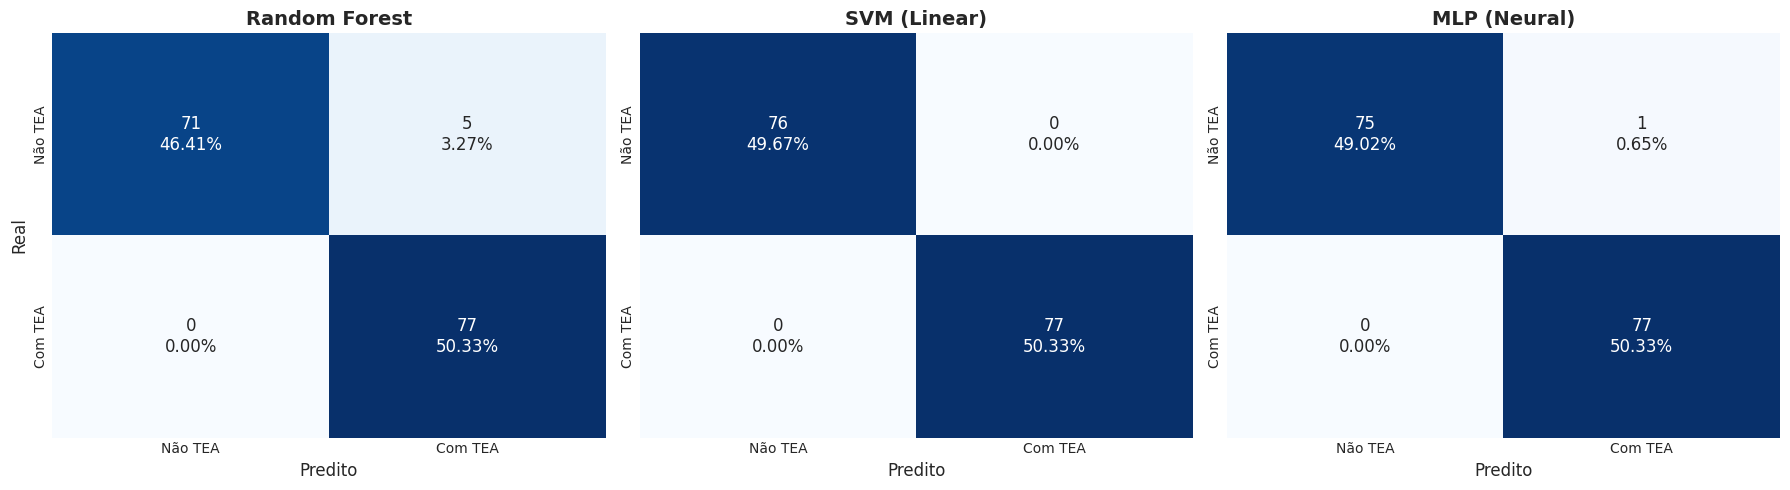


--------------------------------------------------------------------------------
TABELA 1. DESEMPENHO COMPARATIVO (MÉTRICAS CLÍNICAS)
--------------------------------------------------------------------------------


Modelo,Sensibilidade (Recall),Especificidade,Acurácia,Precisão,F1-Score
Random Forest,100.00%,93.42%,96.73%,93.90%,96.86%
SVM (Linear),100.00%,100.00%,100.00%,100.00%,100.00%
MLP (Neural),100.00%,98.68%,99.35%,98.72%,99.35%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set_style("white")

banco_de_modelos = {
    "Random Forest": globals().get('modelo_rf', None),
    "SVM (Linear)":  globals().get('modelo_svm', None),
    "MLP (Neural)":  globals().get('modelo_mlp', None)
}

X_teste_final = globals().get('X_test', None)
y_teste_final = globals().get('y_test', None)

def gerar_relatorio_academico(modelos_dict, X_test, y_test):
    """
    Realiza inferência nos dados de teste e gera relatório de desempenho clínico.

    Processa as predições dos modelos fornecidos e calcula métricas fundamentais
    (Sensibilidade, Especificidade, Acurácia, Precisão, F1). Gera visualizações
    de matriz de confusão e tabela comparativa formatada.

    Args:
        modelos_dict (dict): Dicionário com modelos já treinados.
        X_test (pd.DataFrame): Dados de teste.
        y_test (pd.Series): Gabarito real.
    """
    modelos_ativos = {k: v for k, v in modelos_dict.items() if v is not None}

    if not modelos_ativos or X_test is None or y_test is None:
        print("AVISO: Variáveis de modelo ou dados não encontradas na memória.")
        print("Certifique-se de ter rodado a célula de TREINAMENTO antes desta.")
        return

    resultados_lista = []
    n_cols = len(modelos_ativos)
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 5))
    if n_cols == 1: axes = [axes]

    print(f"Iniciando avaliação de desempenho para {len(modelos_ativos)} modelos...\n")

    for i, (nome, modelo) in enumerate(modelos_ativos.items()):
        try:
            y_pred = modelo.predict(X_test)
        except Exception as e:
            print(f"Erro na predição de {nome}: {e}")
            continue

        try:
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        except ValueError:
            tn, fp, fn, tp = 0, 0, 0, 0

        total = tn + fp + fn + tp
        safe_div = lambda n, d: n / d if d > 0 else 0.0

        resultados_lista.append({
            'Modelo': nome,
            'Sensibilidade (Recall)': safe_div(tp, tp + fn),
            'Especificidade': safe_div(tn, tn + fp),
            'Acurácia': safe_div(tp + tn, total),
            'Precisão': safe_div(tp, tp + fp),
            'F1-Score': safe_div(2 * tp, 2 * tp + fp + fn)
        })

        cm = np.array([[tn, fp], [fn, tp]])
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=axes[i],
                    xticklabels=['Não TEA', 'Com TEA'], yticklabels=['Não TEA', 'Com TEA'],
                    annot_kws={"size": 12})

        axes[i].set_title(f"{nome}", fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Predito', fontsize=12)
        if i == 0: axes[i].set_ylabel('Real', fontsize=12)

    plt.tight_layout()
    plt.show()

    if resultados_lista:
        df = pd.DataFrame(resultados_lista)
        df = df.sort_values(by='Sensibilidade (Recall)', ascending=False)

        print("\n" + "-"*80)
        print("TABELA 1. DESEMPENHO COMPARATIVO (MÉTRICAS CLÍNICAS)")
        print("-"*80)

        format_dict = {col: "{:.2%}" for col in df.columns if col != 'Modelo'}

        try:
            display(df.style.format(format_dict).hide(axis="index"))
        except:
            print(df.to_string(index=False, formatters=format_dict))

gerar_relatorio_academico(banco_de_modelos, X_teste_final, y_teste_final)

## **Avaliação dos resultados**

Além das métricas de desempenho quantitativas, a validação de algoritmos em saúde exige a verificação da coerência clínica das decisões (interpretabilidade). Modelos "caixa-preta" com alta acurácia podem estar baseados em correlações espúrias, o que comprometeria sua aplicação no mundo real.

Para mitigar este risco, aplicamos técnicas de **Explainable AI (XAI)** utilizando valores **SHAP (SHapley Additive exPlanations)**. Esta abordagem baseada na teoria dos jogos nos permite:

* **Hierarquizar Fatores de Risco:** Identificar quais perguntas do instrumento AQ-10 exercem maior influência sobre a predição.

* **Validar Direcionalidade:** Confirmar se pontuações elevadas em itens críticos (ex: déficits sociais) estão correlacionadas positivamente com a classificação de TEA, alinhando o modelo ao conhecimento médico estabelecido.

Abaixo, apresentamos a análise de importância de atributos (Feature Importance) e o impacto direcional (Beeswarm Plot) para os modelos auditados.

--- Análise de Importância de Atributos (N=153) ---

🔹 Modelo: Random Forest
------------------------------------------------------------
Fator de Risco Impacto Médio Desvio Padrão
            A4        0.1000        0.0137
            A8        0.0680        0.0141
            A1        0.0673        0.0173
            A5        0.0562        0.0084
            A9        0.0523        0.0170
           A10        0.0425        0.0102
            A3        0.0359        0.0161
            A7        0.0320        0.0099
           Age        0.0170        0.0032
            A2        0.0150        0.0066
------------------------------------------------------------



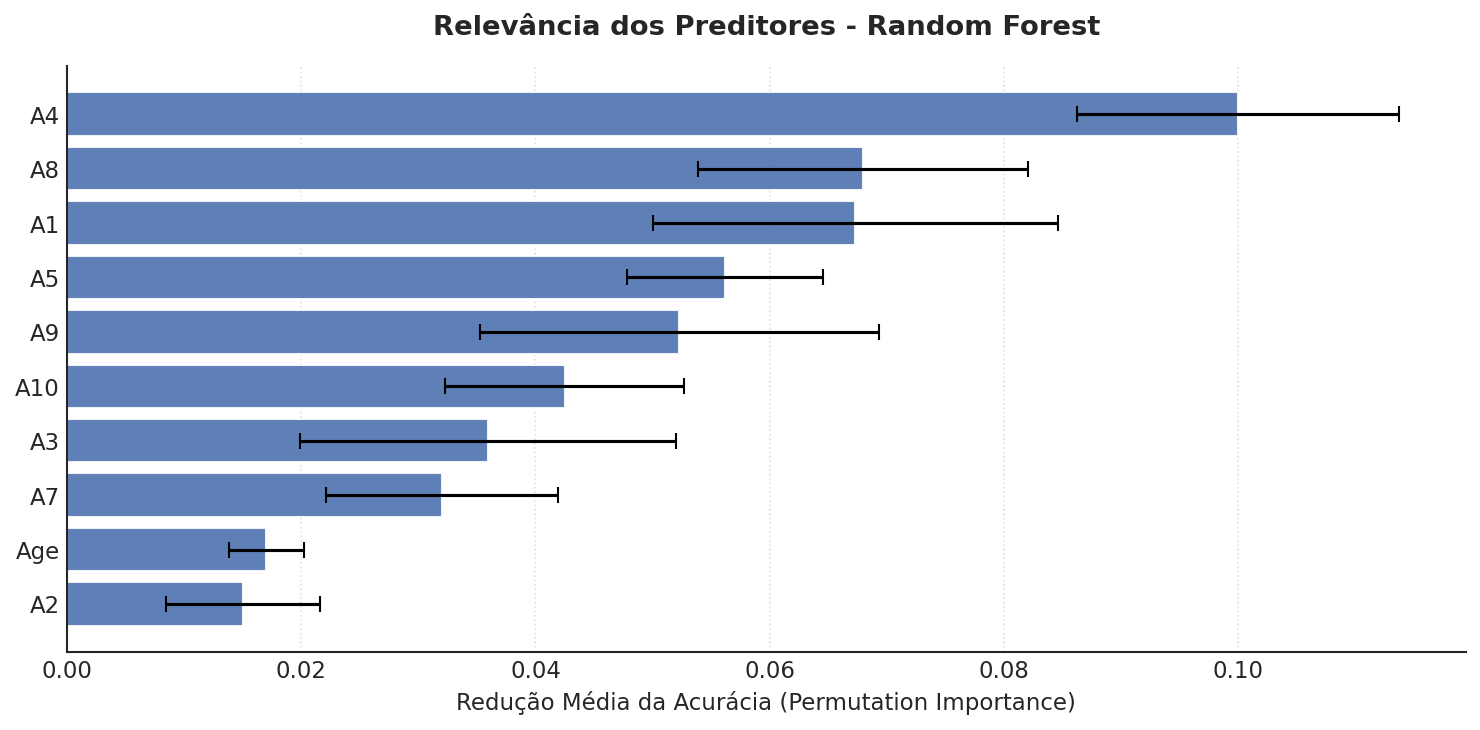



🔹 Modelo: SVM (Linear)
------------------------------------------------------------
Fator de Risco Impacto Médio Desvio Padrão
            A1        0.0935        0.0190
            A7        0.0915        0.0117
            A4        0.0869        0.0072
            A2        0.0686        0.0098
            A9        0.0673        0.0168
            A5        0.0614        0.0098
            A8        0.0595        0.0138
           A10        0.0556        0.0128
            A3        0.0451        0.0090
            A6        0.0242        0.0101
------------------------------------------------------------



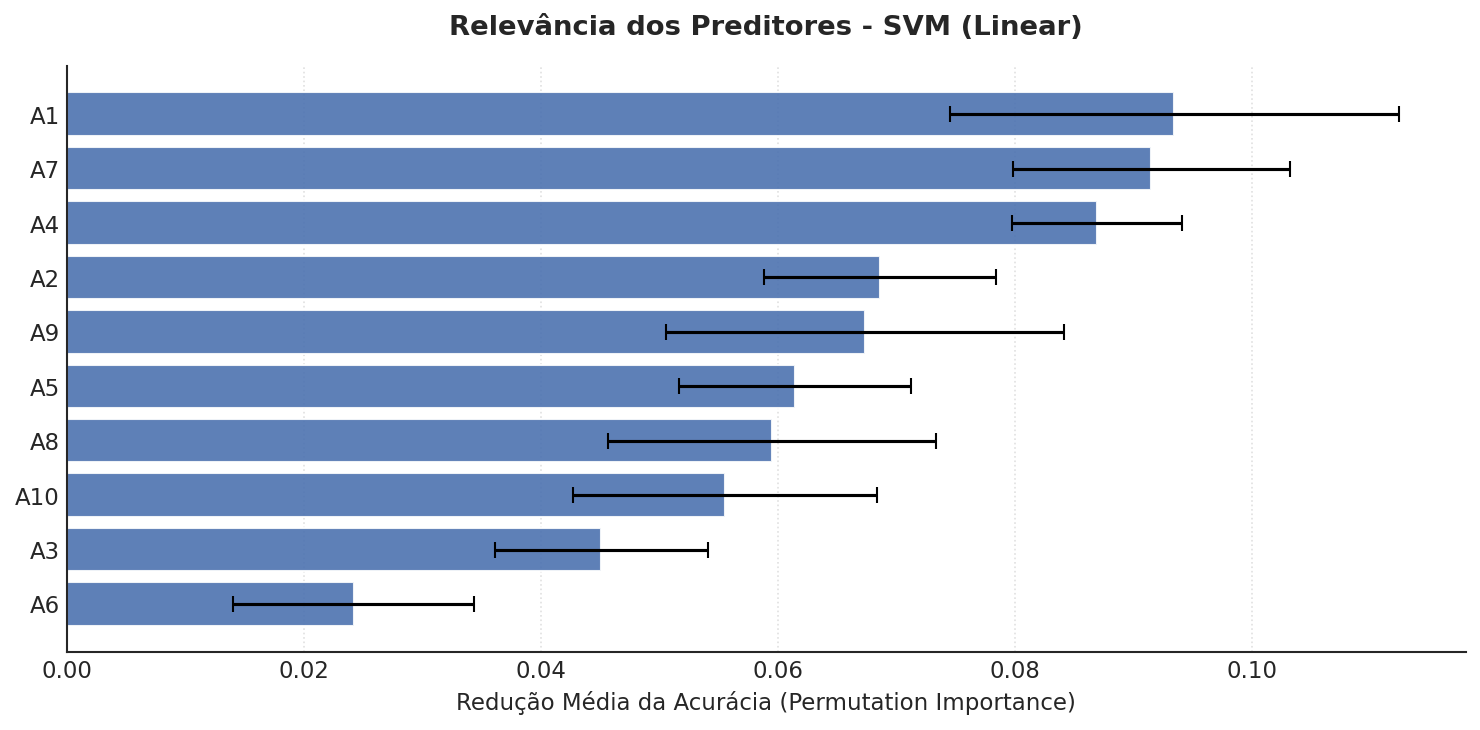



🔹 Modelo: MLP (Neural)
------------------------------------------------------------
Fator de Risco Impacto Médio Desvio Padrão
            A4        0.0922        0.0080
            A1        0.0882        0.0181
            A7        0.0810        0.0166
            A9        0.0647        0.0186
            A5        0.0601        0.0112
           A10        0.0556        0.0150
            A2        0.0549        0.0110
            A8        0.0503        0.0128
            A3        0.0464        0.0080
            A6        0.0268        0.0115
------------------------------------------------------------



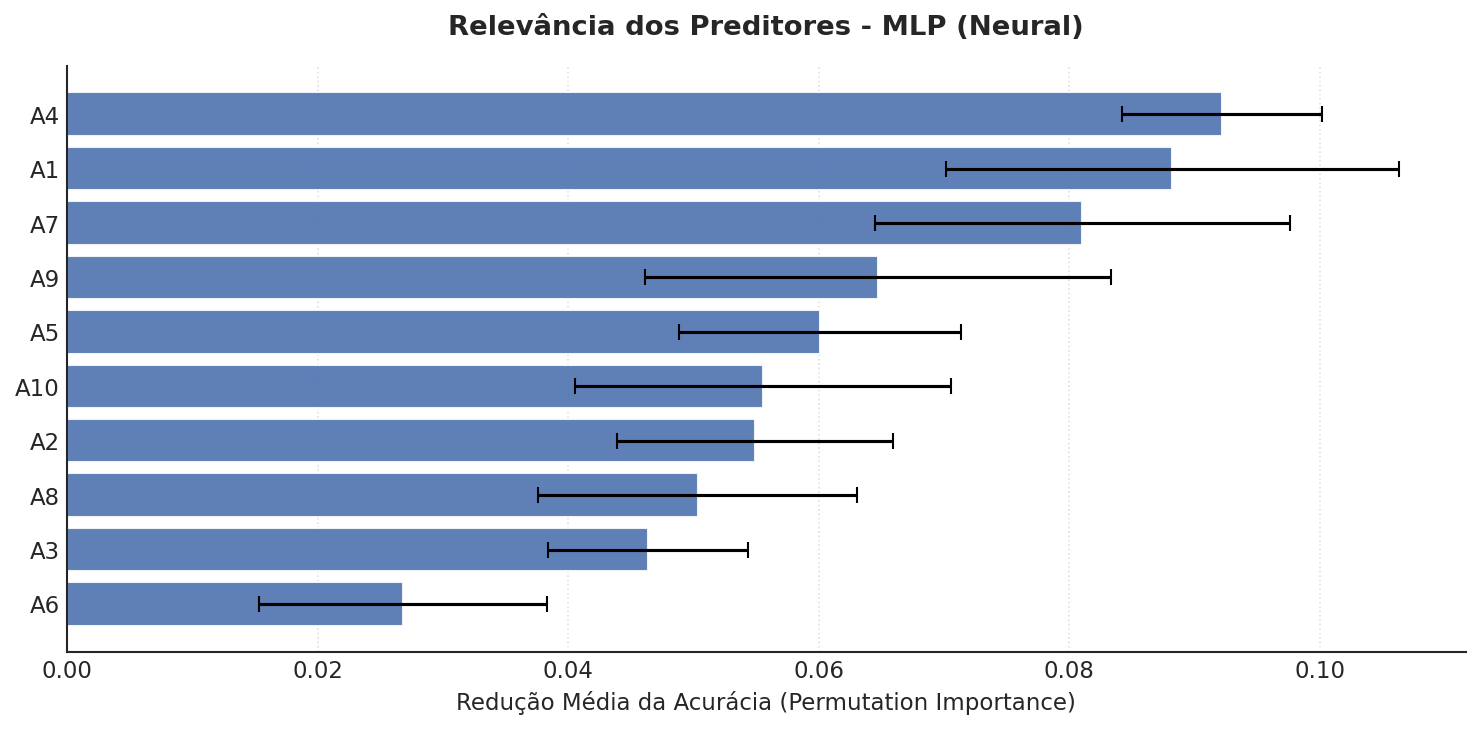

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import warnings

warnings.filterwarnings("ignore")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'figure.dpi': 150,
    'axes.spines.top': False,
    'axes.spines.right': False
})


modelos_avaliados = {
    "Random Forest": globals().get('modelo_rf'),
    "SVM (Linear)":  globals().get('modelo_svm'),
    "MLP (Neural)":  globals().get('modelo_mlp')
}


X_val = globals().get('X_test')
y_val = globals().get('y_test')
X_train_ref = globals().get('X_train')

def extrair_nomes_atributos(X_referencia):
    """Retorna lista de atributos (features) do dataset."""
    if isinstance(X_referencia, pd.DataFrame):
        return X_referencia.columns.tolist()

    return [f"Var_{i}" for i in range(X_referencia.shape[1])]

def calcular_importancia(modelo, X, y, n_repeats=10):
    """
    Executa Permutation Importance para mensurar impacto dos atributos na performance.
    Retorna DataFrame ordenado com média e desvio padrão.
    """
    if X is None or y is None:
        return None

    result = permutation_importance(
        modelo, X, y,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=1
    )

    return pd.DataFrame({
        'Atributo': extrair_nomes_atributos(X),
        'Importancia': result.importances_mean,
        'Desvio': result.importances_std
    }).sort_values(by='Importancia', ascending=False)

def plotar_ranking(df_imp, titulo_modelo):
    """Gera gráfico de barras horizontal com barras de erro (padrão publicação)."""
    plt.figure(figsize=(10, 5))

    df_top = df_imp.head(10)

    plt.barh(
        df_top['Atributo'],
        df_top['Importancia'],
        xerr=df_top['Desvio'],
        align='center',
        color='#4C72B0',
        alpha=0.9,
        capsize=4
    )

    plt.xlabel('Redução Média da Acurácia (Permutation Importance)')
    plt.title(f'Relevância dos Preditores - {titulo_modelo}', fontweight='bold', pad=15)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

if X_val is not None and y_val is not None:
    print(f"--- Análise de Importância de Atributos (N={len(X_val)}) ---\n")

    for nome_modelo, modelo_obj in modelos_avaliados.items():
        if modelo_obj is None:
            continue


        df_resultados = calcular_importancia(modelo_obj, X_val, y_val)


        print(f"🔹 Modelo: {nome_modelo}")
        print("-" * 60)


        cols_show = ['Atributo', 'Importancia', 'Desvio']
        df_display = df_resultados[cols_show].head(10).copy()
        df_display.columns = ['Fator de Risco', 'Impacto Médio', 'Desvio Padrão']


        print(df_display.to_string(index=False, formatters={
            'Impacto Médio': '{:.4f}'.format,
            'Desvio Padrão': '{:.4f}'.format
        }))
        print("-" * 60 + "\n")


        plotar_ranking(df_resultados, nome_modelo)
        print("\n")

else:
    print("Erro: Dados de validação não carregados na memória.")

Conclusão

In [ ]:
import joblib

# 1. Salva o Modelo Campeão (SVM)
joblib.dump(modelo_svm, 'modelo_campeao.pkl')

# 2. Salva o Scaler (Fundamental para a matemática bater)
# O 'scaler' deve ser a variável que você usou no pré-processamento
joblib.dump(scaler, 'scaler.pkl')

# 3. Salva os nomes das colunas (Para garantir a ordem exata)
colunas_treino = X_train.columns.tolist()
joblib.dump(colunas_treino, 'colunas.pkl')

print("✅ Arquivos exportados! Baixe 'modelo_campeao.pkl', 'scaler.pkl' e 'colunas.pkl' do menu de arquivos.")

NameError: name 'modelo_svm' is not defined